## Семинар 2 "Распознавание рукописных цифр"


В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)


In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from hw1_layers import Linear, Sigmoid, NLLLoss, NeuralNetwork
%matplotlib inline

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
train_dataset = MNIST(".", train=True, download=True, transform=transform)
test_dataset = MNIST(".", train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


### Часть 1: MNIST

Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01


In [3]:
def process_model(model, loss, learning_rate, epochs):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        num_batches = len(train_loader)
        total_loss = 0

        for X, y in train_loader:
            X = X.view(X.shape[0], -1)
            X = X.numpy()
            y = y.numpy()

            output = model.forward(X)
            l = loss.forward(output, y)
            total_loss += l

            dLdy = loss.backward()

            model.backward(dLdy)
            model.step(learning_rate)

        avg_loss = total_loss / num_batches
        train_losses.append(avg_loss)
        total_loss = 0

        for X, y in test_loader:
            X = X.view(X.shape[0], -1)
            X = X.numpy()
            y = y.numpy()

            output = model.forward(X)
            l = loss.forward(output, y)
            total_loss += l

        avg_loss = total_loss / num_batches
        test_losses.append(avg_loss)

    return train_losses, test_losses


def model_accuracy(model, loader):
    correct = 0
    total = 0

    for X, y in loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        output = model.forward(X)
        predicted = np.argmax(output, axis=1)
        total += y.shape[0]
        correct += (predicted == y).sum()

    return 100 * correct / total


train accuracy:	 94.82166666666667 %
test accuracy:	 94.57 %


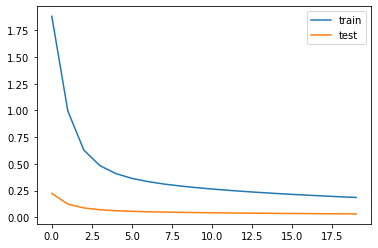

In [4]:
model = NeuralNetwork(
    [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)]
)

train_losses, test_losses = process_model(model, NLLLoss(), 1e-2, 20)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")


plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()


### Часть 2: Нелинейности


Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.


In [5]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        self.s = (X > 0).astype(float) * X
        return self.s

    def backward(self, dLdy):
        return (self.s > 0).astype(float) * dLdy

    def step(self, learning_rate):
        pass


class ELU:
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy * dydX

    def step(self, learning_rate):
        pass


train accuracy:	 99.12333333333333 %
test accuracy:	 97.24 %


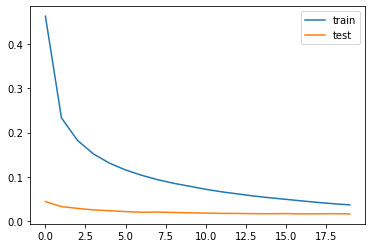

In [6]:
model = NeuralNetwork(
    [Linear(784, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 10)]
)

relu_train_losses, relu_test_losses = process_model(model, NLLLoss(), 1e-2, 20)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")

plt.plot(relu_train_losses, label="train")
plt.plot(relu_test_losses, label="test")
plt.legend()
plt.show()


train accuracy:	 99.10833333333333 %
test accuracy:	 97.09 %


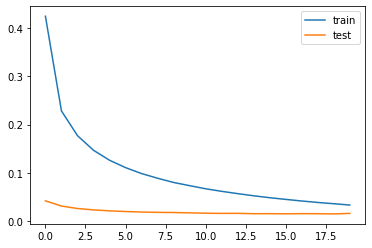

In [7]:
model = NeuralNetwork(
    [Linear(784, 100), ELU(), Linear(100, 100), ELU(), Linear(100, 10)]
)

elu_train_losses, elu_test_losses = process_model(model, NLLLoss(), 1e-2, 20)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")

plt.plot(elu_train_losses, label="train")
plt.plot(elu_test_losses, label="test")
plt.legend()
plt.show()


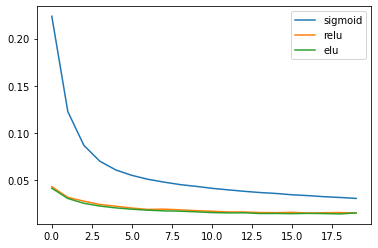

In [8]:
plt.plot(test_losses, label="sigmoid")
plt.plot(relu_test_losses, label="relu")
plt.plot(elu_test_losses, label="elu")
plt.legend()
plt.show()


### HW1 (1 балл): Реализовать Tanh


In [9]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        self.X = X

        return self.__formula(X)

    def backward(self, dLdy):
        dydX = 1 - self.__formula(self.X) ** 2
        return dLdy * dydX

    def __formula(self, X):
        return (np.exp(2 * X) - 1) / (np.exp(2 * X) + 1)

    def step(self, learning_rate):
        pass


train accuracy:	 98.88833333333334 %
test accuracy:	 96.32 %


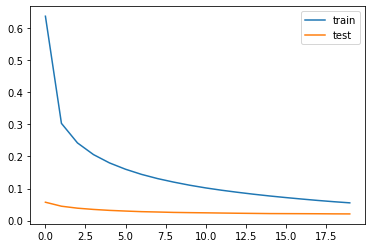

In [10]:
model = NeuralNetwork(
    [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
)

tanh_train_losses, tanh_test_losses = process_model(model, NLLLoss(), 1e-2, 20)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")

plt.plot(tanh_train_losses, label="train")
plt.plot(tanh_test_losses, label="test")
plt.legend()
plt.show()


### Часть 3: Анализ ошибок

На каких объектах сеть ошибается больше всего?


In [ ]:
# непонятно какая модель именно из обученных, пусть с tanh, ибо для него интереснее всего т.к. задано его реализовать


In [11]:
wrong_X = []
correct_y = []
predicted_y = []
error = []

for X, y in test_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy()
    y = y.numpy()

    output = model.forward(X)
    predicted = np.argmax(output, axis=1)
    losses = np.exp(output) / output.sum(1, keepdims=True)

    for i in range(len(predicted)):
        if predicted[i] != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(predicted[i])
            error.append(losses[i][y[i]])

wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
error = np.row_stack(error)[:, 0]


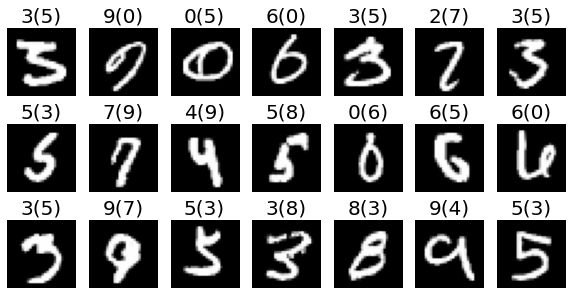

In [12]:
plt.figure(figsize=(10, 5))
order = np.argsort(error)
for i in range(21):
    plt.subplot(3, 7, i + 1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title("{}({})".format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis("off")


### Часть 4: Аугментация (HW, 2 балла)

-   Небольшие вращения (-15, 15)
-   Случайные сдвиги
-   Шум

Какой прирост дают эти аугментации вместе и по отдельности


train accuracy:	 96.77666666666667 %
test accuracy:	 96.95 %


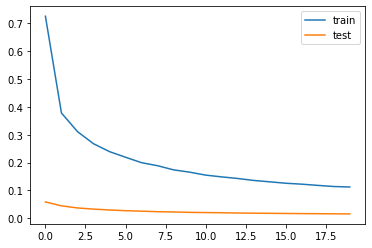

In [13]:
transform = transforms.Compose(
    [
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
train_dataset = MNIST(".", train=True, download=True, transform=transform)
test_dataset = MNIST(
    ".",
    train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

model = NeuralNetwork(
    [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
)

rotated_tanh_train_losses, rotated_tanh_test_losses = process_model(
    model, NLLLoss(), 0.01, 20
)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")

plt.plot(rotated_tanh_train_losses, label="train")
plt.plot(rotated_tanh_test_losses, label="test")
plt.legend()
plt.show()


train accuracy:	 94.69666666666667 %
test accuracy:	 96.53 %


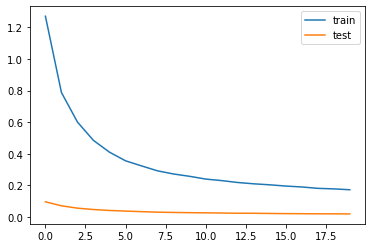

In [14]:
transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=0, translate=(0.10, 0.10)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
train_dataset = MNIST(".", train=True, download=True, transform=transform)
test_dataset = MNIST(
    ".",
    train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

model = NeuralNetwork(
    [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
)

shifted_tanh_train_losses, shifted_tanh_test_losses = process_model(
    model, NLLLoss(), 0.01, 20
)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")

plt.plot(shifted_tanh_train_losses, label="train")
plt.plot(shifted_tanh_test_losses, label="test")
plt.legend()
plt.show()


train accuracy:	 97.775 %
test accuracy:	 96.69 %


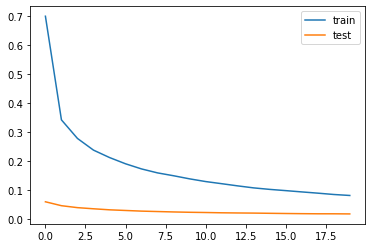

In [15]:
from torch import randn


class Noise:
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, image):
        return image + self.scale * randn(image.shape)


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        Noise(0.075),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
train_dataset = MNIST(".", train=True, download=True, transform=transform)
test_dataset = MNIST(
    ".",
    train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

model = NeuralNetwork(
    [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
)

noised_tanh_train_losses, noised_tanh_test_losses = process_model(
    model, NLLLoss(), 0.01, 20
)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")

plt.plot(noised_tanh_train_losses, label="train")
plt.plot(noised_tanh_test_losses, label="test")
plt.legend()
plt.show()


train accuracy:	 55.24166666666667 %
test accuracy:	 84.57 %


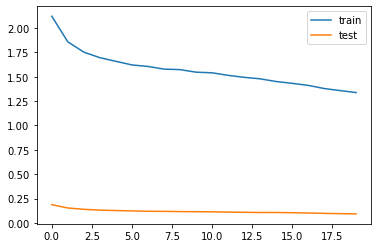

In [16]:
transform = transforms.Compose(
    [
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.RandomAffine(degrees=0, translate=(0.10, 0.10)),
        transforms.ToTensor(),
        Noise(0.75),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
train_dataset = MNIST(".", train=True, download=True, transform=transform)
test_dataset = MNIST(
    ".",
    train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

model = NeuralNetwork(
    [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
)

augmented_tanh_train_losses, augmented_tanh_test_losses = process_model(
    model, NLLLoss(), 0.01, 20
)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")

plt.plot(augmented_tanh_train_losses, label="train")
plt.plot(augmented_tanh_test_losses, label="test")
plt.legend()
plt.show()


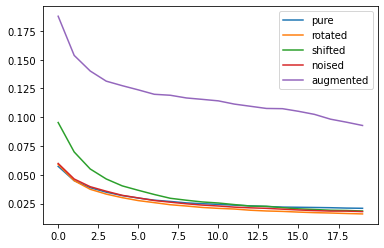

In [17]:
plt.plot(tanh_test_losses, label="pure")
plt.plot(rotated_tanh_test_losses, label="rotated")
plt.plot(shifted_tanh_test_losses, label="shifted")
plt.plot(noised_tanh_test_losses, label="noised")
plt.plot(augmented_tanh_test_losses, label="augmented")
plt.legend()
plt.show()


Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.


train accuracy:	 68.61 %
test accuracy:	 93.09 %


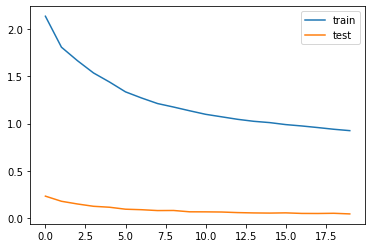

In [18]:
model = NeuralNetwork(
    [Linear(784, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 10)]
)

augmented_relu_train_losses, augmented_relu_test_losses = process_model(
    model, NLLLoss(), 0.01, 20
)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")

plt.plot(augmented_relu_train_losses, label="train")
plt.plot(augmented_relu_test_losses, label="test")
plt.legend()
plt.show()


train accuracy:	 69.22333333333333 %
test accuracy:	 92.79 %


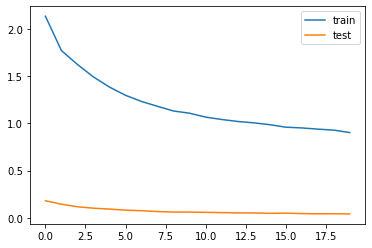

In [19]:
model = NeuralNetwork(
    [Linear(784, 100), ELU(), Linear(100, 100), ELU(), Linear(100, 10)]
)

augmented_elu_train_losses, augmented_elu_test_losses = process_model(
    model, NLLLoss(), 0.01, 20
)

print(f"train accuracy:\t {model_accuracy(model, train_loader)} %")
print(f"test accuracy:\t {model_accuracy(model, test_loader)} %")

plt.plot(augmented_elu_train_losses, label="train")
plt.plot(augmented_elu_test_losses, label="test")
plt.legend()
plt.show()


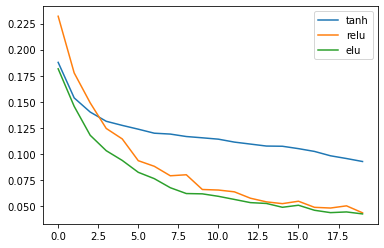

In [20]:
plt.plot(augmented_tanh_test_losses, label="tanh")
plt.plot(augmented_relu_test_losses, label="relu")
plt.plot(augmented_elu_test_losses, label="elu")
plt.legend()
plt.show()


### Часть 5: Выводы

Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?


In [ ]:
# сходимость с аугментацией медленнее, но порой качество на тесте выше чем на трейне, т.е. намного лучше устойчивость к оверфитту. relu и elu показали себя лучше других в задаче. Аугментации кроме сдвигов даже улучшали итоговое качество, сдвиги же немного его ухудшили по отдельности, а добавляя всё вместе ухудшили общий результат существенно. Возможно, обучая дольше вышло бы улучшение, т.к. тяжелые аугментации, видно что даже на трейне очень низкая точность, т.е. можно учить дольше. relu и elu также лучше себя показали на аугментированных данных